In [69]:
import geopandas as gpd
import numpy as np
import math
from __future__ import division
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString

# 计算两点距离
def cal_dist(point_1, point_2):
    dist = np.sqrt(np.sum(np.power((point_1-point_2), 2)))
    return dist


# 计算两条线的夹角
def cal_ang(point_1, point_2, point_3):
    """
    根据三点坐标计算夹角
    :param point_1: 点1坐标
    :param point_2: 点2坐标
    :param point_3: 点3坐标
    :return: 返回任意角的夹角值，这里只是返回点2的夹角
    """
    a=math.sqrt((point_2[0]-point_3[0])*(point_2[0]-point_3[0])+(point_2[1]-point_3[1])*(point_2[1] - point_3[1]))
    b=math.sqrt((point_1[0]-point_3[0])*(point_1[0]-point_3[0])+(point_1[1]-point_3[1])*(point_1[1] - point_3[1]))
    c=math.sqrt((point_1[0]-point_2[0])*(point_1[0]-point_2[0])+(point_1[1]-point_2[1])*(point_1[1]-point_2[1]))
    A=math.degrees(math.acos((a*a-b*b-c*c)/(-2*b*c)))
    B=math.degrees(math.acos((b*b-a*a-c*c)/(-2*a*c)))
    C=math.degrees(math.acos((c*c-a*a-b*b)/(-2*a*b)))
    return B


# 计算线条的方位角
def azimuthAngle(point_0, point_1):
    x1, y1 = point_0
    x2, y2 = point_1

    if x1 < x2:
        if y1 < y2:
            ang = math.atan((y2 - y1) / (x2 - x1))
            ang = ang * 180 / math.pi
            return ang
        elif y1 > y2:
            ang = math.atan((y1 - y2) / (x2 - x1))
            ang = ang * 180 / math.pi
            return 90 + (90 - ang)
        elif y1==y2:
            return 0
    elif x1 > x2:
        if y1 < y2:
            ang = math.atan((y2-y1)/(x1-x2))
            ang = ang*180/math.pi
            return 90+(90-ang)
        elif y1 > y2:
            ang = math.atan((y1-y2)/(x1-x2))
            ang = ang * 180 / math.pi
            return ang
        elif y1==y2:
            return 0

    elif x1==x2:
        return 90

# 线生成函数
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C


# 计算两条直线之间的交点
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return False


# 计算两个平行线之间的距离
def par_line_dist(L1, L2):
    A1, B1, C1 = L1
    A2, B2, C2 = L2

    new_A1 = 1
    new_B1 = B1 / A1
    new_C1 = C1 / A1

    new_A2 = 1
    new_B2 = B2 / A2
    new_C2 = C2 / A2

    dist = (np.abs(new_C1-new_C2))/(np.sqrt(new_A2*new_A2+new_B2*new_B2))
    return dist


# 计算点在直线的投影位置
def point_in_line(m, n, x1, y1, x2, y2):
    x = (m * (x2 - x1) * (x2 - x1) + n * (y2 - y1) * (x2 - x1) + (x1 * y2 - x2 * y1) * (y2 - y1)) / ((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1))
    y = (m * (x2 - x1) * (y2 - y1) + n * (y2 - y1) * (y2 - y1) + (x2 * y1 - x1 * y2) * (x2 - x1)) / ((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1))
    return (x, y)


"""
rdp
~~~
Pure Python implementation of the Ramer-Douglas-Peucker algorithm.
:copyright: (c) 2014 Fabian Hirschmann <fabian@hirschmann.email>
:license: MIT, see LICENSE.txt for more details.
"""


def pldist(x0, x1, x2):
    """
    Calculates the distance from the point ``x0`` to the line given
    by the points ``x1`` and ``x2``.
    :param x0: a point
    :type x0: a 2x1 numpy array
    :param x1: a point of the line
    :type x1: 2x1 numpy array
    :param x2: another point of the line
    :type x2: 2x1 numpy array
    """
    x0, x1, x2 = x0[:2], x1[:2], x2[:2] # discard timestamp
    if x1[0] == x2[0]:
        return np.abs(x0[0] - x1[0])

    return np.divide(np.linalg.norm(np.linalg.det([x2 - x1, x1 - x0])),
                     np.linalg.norm(x2 - x1))


def _rdp(M, epsilon, dist):
    """
    Simplifies a given array of points.
    :param M: an array
    :type M: Nx2 numpy array
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(x1, x2, x3)``
    """
    dmax = 0.0
    index = -1

    for i in range(1, M.shape[0]):
        d = dist(M[i], M[0], M[-1])

        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        r1 = _rdp(M[:index + 1], epsilon, dist)
        r2 = _rdp(M[index:], epsilon, dist)

        return np.vstack((r1[:-1], r2))
    else:
        return np.vstack((M[0], M[-1]))


def _rdp_nn(seq, epsilon, dist):
    """
    Simplifies a given array of points.
    :param seq: a series of points
    :type seq: sequence of 2-tuples
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(x1, x2, x3)``
    """
    return _rdp(np.array(seq), epsilon, dist).tolist()


def rdp(M, epsilon=0, dist=pldist):
    """
    Simplifies a given array of points.
    :param M: a series of points
    :type M: either a Nx2 numpy array or sequence of 2-tuples
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(x1, x2, x3)``
    """
    if "numpy" in str(type(M)):
        return _rdp(M, epsilon, dist)
    return _rdp_nn(M, epsilon, dist)


# 顺时针旋转
def Nrotation_angle_get_coor_coordinates(point, center, angle):
    src_x, src_y = point
    center_x, center_y = center
    radian = math.radians(angle)

    dest_x = (src_x - center_x) * math.cos(radian) + (src_y - center_y) * math.sin(radian) + center_x
    dest_y = (src_y - center_y) * math.cos(radian) - (src_x - center_x) * math.sin(radian) + center_y

    # return (int(dest_x), int(dest_y))
    return (dest_x, dest_y)


# 逆时针旋转
def Srotation_angle_get_coor_coordinates(point, center, angle):
    src_x, src_y = point
    center_x, center_y = center
    radian = math.radians(angle)

    dest_x = (src_x - center_x) * math.cos(radian) - (src_y - center_y) * math.sin(radian) + center_x
    dest_y = (src_x - center_x) * math.sin(radian) + (src_y - center_y) * math.cos(radian) + center_y

    # return [int(dest_x), int(dest_y)]
    return (dest_x, dest_y)

def boundary_regularization_gdf(input_gdf, epsilon=6):
    """
    对 GeoDataFrame 中的建筑边界进行规则化处理，使得角度尽量接近 90 度或 45 度。
    :param input_gdf: 输入的 GeoDataFrame。
    :param epsilon: RDP 精简算法的参数。
    :return: 规则化后的 GeoDataFrame。
    """
    output_gdf = input_gdf.copy()

    def regularize_geometry(geometry):
        if geometry.is_empty or not isinstance(geometry, (Polygon, MultiPolygon)):
            return geometry  # 跳过空几何或非多边形几何

        if isinstance(geometry, MultiPolygon):
            polygons = [
                Polygon(boundary_regularization(np.array(poly.exterior.coords), epsilon))
                for poly in geometry.geoms if len(poly.exterior.coords) >= 3
            ]
            return MultiPolygon(polygons) if polygons else None
        else:
            regularized_coords = boundary_regularization(np.array(geometry.exterior.coords), epsilon)
            if len(regularized_coords) < 3:  # 如果点数不足 3，返回原始几何
                return geometry
            return Polygon(regularized_coords)

    output_gdf['geometry'] = output_gdf['geometry'].apply(regularize_geometry)
    
    return output_gdf


def boundary_regularization(coords, epsilon):
    """
    使用规则化算法处理边界。
    :param coords: 原始边界坐标数组（Nx2）。
    :param epsilon: RDP 精简算法的参数。
    :return: 规则化后的边界坐标数组。
    """
    # RDP 精简边界
    coords = rdp(coords, epsilon=epsilon)
    # 如果点数不足以构成多边形，返回原始坐标
    if len(coords) < 3:
        return coords
    
    dists = []
    azis = []
    azis_index = []

    # 获取每条边的长度和方位角
    for i in range(len(coords)):
        cur_index = i
        next_index = (i + 1) % len(coords)
        cur_point = coords[cur_index]
        next_point = coords[next_index]

        dist = cal_dist(cur_point, next_point)
        azi = azimuthAngle(cur_point, next_point)

        dists.append(dist)
        azis.append(azi)
        azis_index.append([cur_index, next_index])

    # 以最长边的方向为主方向
    longest_edge_index = np.argmax(dists)
    main_direction = azis[longest_edge_index]

    correct_points = []
    para_vetr_idxs = []

    for i, (azi, (point_0_index, point_1_index)) in enumerate(zip(azis, azis_index)):
        if i == longest_edge_index:
            correct_points.append([coords[point_0_index], coords[point_1_index]])
            para_vetr_idxs.append(0)
        else:
            rotate_ang = main_direction - azi

            if abs(rotate_ang) < 180 / 4:
                para_vetr_idxs.append(0)
            elif abs(rotate_ang) >= 90 - 180 / 4:
                rotate_ang += 90
                para_vetr_idxs.append(1)

            point_0 = coords[point_0_index]
            point_1 = coords[point_1_index]
            point_middle = (point_0 + point_1) / 2

            if rotate_ang > 0:
                rotate_point_0 = Srotation_angle_get_coor_coordinates(point_0, point_middle, abs(rotate_ang))
                rotate_point_1 = Srotation_angle_get_coor_coordinates(point_1, point_middle, abs(rotate_ang))
            else:
                rotate_point_0 = Nrotation_angle_get_coor_coordinates(point_0, point_middle, abs(rotate_ang))
                rotate_point_1 = Nrotation_angle_get_coor_coordinates(point_1, point_middle, abs(rotate_ang))

            correct_points.append([rotate_point_0, rotate_point_1])

    correct_points = np.array(correct_points, dtype=object)

    final_points = []
    final_points.append(correct_points[0][0])

    for i in range(len(correct_points) - 1):
        cur_edge = correct_points[i]
        next_edge = correct_points[(i + 1) % len(correct_points)]

        if para_vetr_idxs[i] != para_vetr_idxs[(i + 1) % len(correct_points)]:
            L1 = line(*cur_edge)
            L2 = line(*next_edge)
            inter = intersection(L1, L2)
            if inter:
                final_points.append(inter)
        else:
            final_points.append(cur_edge[1])

    final_points.append(final_points[0])
    return np.array(final_points, dtype=float)



In [189]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from shapely.affinity import rotate
from shapely.validation import make_valid
import numpy as np


def calculate_main_direction(polygon):
    """
    计算多边形的主方向。

    :param polygon: Shapely 的多边形对象
    :return: 主方向角度（相对于水平轴的逆时针角度，单位为度）
    """
    min_rect = polygon.minimum_rotated_rectangle
    coords = np.array(min_rect.exterior.coords[:-1])  # 最小外接矩形的顶点

    # 计算最长边的方向
    edge_vectors = coords[1:] - coords[:-1]
    edge_lengths = np.linalg.norm(edge_vectors, axis=1)
    longest_edge_index = np.argmax(edge_lengths)
    main_edge = edge_vectors[longest_edge_index]

    angle = np.arctan2(main_edge[1], main_edge[0]) * 180 / np.pi  # 转换为度数
    return angle


def douglas_peucker(coords, epsilon):
    """
    实现 Douglas-Peucker 折线简化算法。

    :param coords: 输入的坐标列表 [(x1, y1), (x2, y2), ...]
    :param epsilon: 距离阈值
    :return: 简化后的坐标列表
    """
    if len(coords) < 3:
        return coords

    # 找到距离起点和终点连线最远的点
    start, end = coords[0], coords[-1]
    line = LineString([start, end])
    max_distance = 0
    index = 0

    for i in range(1, len(coords) - 1):
        point = coords[i]
        distance = line.distance(Point(point))
        if distance > max_distance:
            max_distance = distance
            index = i

    # 如果最大距离大于阈值，则递归处理
    if max_distance > epsilon:
        left = douglas_peucker(coords[:index + 1], epsilon)
        right = douglas_peucker(coords[index:], epsilon)
        return left[:-1] + right
    else:
        return [start, end]


def enforce_right_angles(coords):
    """
    调整多边形的角点以尽量保证每个角为 90 度。

    :param coords: 输入的坐标列表 [(x1, y1), (x2, y2), ...]
    :return: 调整后的坐标列表
    """
    adjusted_coords = [coords[0]]

    for i in range(1, len(coords) - 1):
        prev_point = adjusted_coords[-1]
        curr_point = coords[i]
        next_point = coords[i + 1]

        # 计算向量
        vector1 = np.array(curr_point) - np.array(prev_point)
        vector2 = np.array(next_point) - np.array(curr_point)

        # 判断是否接近 90 度
        dot_product = np.dot(vector1, vector2)
        magnitude1 = np.linalg.norm(vector1)
        magnitude2 = np.linalg.norm(vector2)
        cos_angle = dot_product / (magnitude1 * magnitude2)

        # 如果角度不是 90 度，调整当前点
        if not np.isclose(cos_angle, 0, atol=0.1):
            if abs(vector1[0]) > abs(vector1[1]):
                adjusted_point = (curr_point[0], prev_point[1])
            else:
                adjusted_point = (prev_point[0], curr_point[1])
            adjusted_coords.append(adjusted_point)
        else:
            adjusted_coords.append(curr_point)

    adjusted_coords.append(coords[-1])  # 闭合多边形
    return adjusted_coords


def simplify_polygon_with_dp_and_angles(polygon, epsilon):
    """
    使用 Douglas-Peucker 算法简化多边形，并尽量保证每个角为 90 度。

    :param polygon: 输入的 Shapely 多边形
    :param epsilon: 距离阈值
    :return: 简化后的多边形
    """
    if polygon.is_empty or not polygon.is_valid:
        return polygon

    coords = list(polygon.exterior.coords)
    simplified_coords = douglas_peucker(coords, epsilon)
    adjusted_coords = enforce_right_angles(simplified_coords)

    if len(adjusted_coords) < 3:
        return polygon  # 无法构成多边形，返回原始多边形

    simplified_polygon = Polygon(adjusted_coords)

    # 检查多边形是否有效，并自动修复
    if not simplified_polygon.is_valid:
        simplified_polygon = make_valid(simplified_polygon)

    return simplified_polygon


def snap_to_main_direction(polygon, grid_size=1, epsilon=1):
    """
    将多边形规则化为与主方向平行的简化形状，并尽量保证每个角为 90 度。

    :param polygon: Shapely 的多边形对象
    :param grid_size: 网格大小，控制对齐精度
    :param epsilon: Douglas-Peucker 算法的距离阈值
    :return: 规则化后的多边形
    """
    if polygon.is_empty or not polygon.is_valid:
        return polygon

    # 计算主方向并旋转到水平
    main_angle = calculate_main_direction(polygon)
    rotated_polygon = rotate(polygon, -main_angle, origin='centroid', use_radians=False)

    # 使用 Douglas-Peucker 算法简化并调整角度
    simplified_polygon = simplify_polygon_with_dp_and_angles(rotated_polygon, epsilon)

    # 将规则化后的多边形旋转回原始方向
    final_polygon = rotate(simplified_polygon, main_angle, origin='centroid', use_radians=False)

    # 检查最终多边形是否有效，并自动修复
    if not final_polygon.is_valid:
        final_polygon = make_valid(final_polygon)

    return final_polygon


def regularize_geodataframe(gdf, grid_size=1, epsilon=1):
    """
    对 GeoDataFrame 中的所有几何对象进行规则化处理。

    :param gdf: 输入的 GeoDataFrame
    :param grid_size: 网格大小，控制对齐精度
    :param epsilon: Douglas-Peucker 算法的距离阈值
    :return: 规则化后的 GeoDataFrame
    """
    # 确保输入 GeoDataFrame 有 'geometry' 列
    if 'geometry' not in gdf.columns:
        raise ValueError("GeoDataFrame must have a 'geometry' column.")

    # 复制输入数据，防止修改原数据
    gdf_regularized = gdf.copy()

    # 应用规则化函数到每个几何对象
    gdf_regularized['geometry'] = gdf_regularized['geometry'].apply(
        lambda geom: snap_to_main_direction(geom, grid_size, epsilon) if geom else geom
    )

    return gdf_regularized


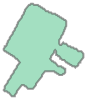

In [190]:
geojson_path = '../Test_image/prediction_Result/Kaga_2_1_2.geojson'
gdf = gpd.read_file(geojson_path)
# gdf = gdf.iloc[0:9]
gdf.geometry[27]


In [136]:
gdf.geometry[5].exterior.coords.xy

(array('d', [15179417.249344306, 15179414.10221997, 15179413.652630778, 15179412.753452398, 15179412.753452398, 15179413.20304159, 15179413.652630778, 15179413.652630778, 15179414.10221997, 15179417.249344306, 15179417.698933499, 15179420.396468641, 15179420.846057834, 15179421.745236214, 15179422.194825407, 15179422.644414596, 15179423.54359298, 15179424.442771362, 15179424.892360551, 15179426.690717313, 15179426.690717313, 15179426.241128122, 15179426.241128122, 15179424.442771362, 15179424.442771362, 15179425.341949742, 15179425.341949742, 15179424.442771362, 15179423.99318217, 15179422.194825407, 15179421.745236214, 15179420.396468641, 15179419.946879452, 15179419.047701072, 15179417.249344306]),
 array('d', [4347266.358963589, 4347262.455080456, 4347262.455080456, 4347261.339685535, 4347260.224290731, 4347260.224290731, 4347259.666593371, 4347259.108896041, 4347259.108896041, 4347255.205015539, 4347255.205015539, 4347251.858833379, 4347251.858833379, 4347250.743439556, 4347250.743

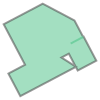

In [191]:
grid_size = 1  # 设置网格大小
gdf_regularized = regularize_geodataframe(gdf, grid_size)
gdf_regularized.geometry[27]

In [22]:
gdf.geometry

0    POLYGON ((15179430.287 4347275.282, 15179428.9...
1    POLYGON ((15179404.211 4347242.936, 15179404.2...
2    POLYGON ((15179563.366 4347371.207, 15179560.2...
3    POLYGON ((15179428.939 4347327.706, 15179428.4...
4    POLYGON ((15179494.579 4347276.955, 15179494.1...
5    POLYGON ((15179417.249 4347266.359, 15179414.1...
6    POLYGON ((15179415.901 4347303.167, 15179414.5...
7    POLYGON ((15179420.396 4347313.763, 15179420.3...
8    POLYGON ((15179473.448 4347168.762, 15179472.5...
Name: geometry, dtype: geometry

In [21]:
gdf

,geometry
0,"POLYGON ((15179430.287 4347275.282, 15179428.9..."
1,"POLYGON ((15179404.211 4347242.936, 15179404.2..."
2,"POLYGON ((15179563.366 4347371.207, 15179560.2..."
3,"POLYGON ((15179428.939 4347327.706, 15179428.4..."
4,"POLYGON ((15179494.579 4347276.955, 15179494.1..."
5,"POLYGON ((15179417.249 4347266.359, 15179414.1..."
6,"POLYGON ((15179415.901 4347303.167, 15179414.5..."
7,"POLYGON ((15179420.396 4347313.763, 15179420.3..."
8,"POLYGON ((15179473.448 4347168.762, 15179472.5..."
